In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker, MarkerCluster
from IPython.display import display, Markdown

<center>
    <h1>
    <strong>Project #4: Advanced Analysis</strong>
    <br/>
    </h1>
    <h5>
        <strong>Collaborators</strong>: Eric F, Rusty B, Sam L<br/><br/>
    </h5>
</center>
    <h5>
        Description: For our Project #4 we aimed to deliver an analysis describing the combative epicenters of the ongoing conflict in Ukraine, 
        then using our knowledge of these points generate locations for humanitarian efforts so they may serve the most people with minimal risk to their own facilities.
        We accomplished this with a maximum coverage algorithm, danger buffers, and intersection density analysis.
    </h5>


<center><h2><strong>Data Sources</strong></h2></center>
<ul>
    <li>ACLED (Armed Conflict Location & Event Data), https://acleddata.com/data/</li>
    <li>OCHA Humanitarian Data Exchange, https://data.humdata.org/dataset/hotosm_ukr_roads</li>
</ul>


In [2]:
#Reading and Cleaning Data
acled_data = pd.read_csv('./ACLED_DATA_PREVIOUSYEAR.csv') 
gdf = gpd.GeoDataFrame(
    acled_data, geometry=gpd.points_from_xy(acled_data.longitude, acled_data.latitude), crs="EPSG:4326"
)
filtered_gdf = gdf[gdf['fatalities']>0]
ua = gpd.read_file("./ua.json")
roads = gpd.read_file("./Ukraine_-_roads/Ukraine_-_roads.shp")
roads.to_crs("EPSG:4326")


,FID,MED_DESCRI,RTT_DESCRI,F_CODE_DES,ISO,ISOCOUNTRY,Shape__Len,geometry
0,1,Unknown,Unknown,Road,UKR,UKRAINE,39558.773041,"LINESTRING (38.58720 49.09414, 38.58469 49.086..."
1,2,Unknown,Unknown,Road,UKR,UKRAINE,7772.898511,"LINESTRING (26.93383 49.08428, 26.93942 49.091..."
2,3,Without Median,Secondary Route,Road,UKR,UKRAINE,32925.829008,"LINESTRING (30.94397 49.08350, 30.93869 49.084..."
3,4,Without Median,Secondary Route,Road,UKR,UKRAINE,12410.778666,"LINESTRING (38.82147 49.08294, 38.82214 49.113..."
4,5,Without Median,Secondary Route,Road,UKR,UKRAINE,17061.784837,"LINESTRING (33.77845 49.17197, 33.76989 49.169..."
...,...,...,...,...,...,...,...,...
6790,6791,Without Median,Primary Route,Road,UKR,NaN,121.576594,"LINESTRING (26.80669 48.25084, 26.80674 48.25011)"
6791,6792,Without Median,Primary Route,Road,UKR,NaN,1752.601947,"LINESTRING (22.87774 47.98843, 22.86856 47.97987)"
6792,6793,Without Median,Primary Route,Road,UKR,NaN,2261.958812,"LINESTRING (28.37478 45.52785, 28.36043 45.51777)"
6793,6794,Without Median,Primary Route,Road,UKR,NaN,3325.456951,"LINESTRING (28.35388 45.51840, 28.35128 45.524..."


<center><h2><strong>Final Plot</strong></h2></center>

In [19]:
# Ensure CRS consistency between datasets
roads = roads.to_crs("EPSG:3857")
places = places.to_crs("EPSG:3857")

# Define a buffer around conflict zones (e.g., 50 km)
conflict_buffer = places.buffer(50000)

# Calculate road density around conflict zones
road_density = gpd.sjoin(roads, gpd.GeoDataFrame(geometry=conflict_buffer), how='inner', predicate='intersects')

road_density['road_length'] = road_density.geometry.length

# Summarize road length per conflict zone
road_length_summary = road_density.groupby('index_right')['road_length'].sum().reset_index()
road_length_summary.columns = ['conflict_zone', 'total_road_length']

# Merge back to the conflict dataset
places['total_road_length'] = places.index.map(
    road_length_summary.set_index('conflict_zone')['total_road_length']
)
places['total_road_length'] = places['total_road_length'].fillna(0)


# Ensure CRS is consistent
roads = roads.to_crs("EPSG:3857")
places = places.to_crs("EPSG:3857")

# Calculate intersections
intersections = gpd.overlay(roads, roads, how='intersection')

# Drop duplicate intersections
intersections['geometry'] = intersections.geometry.apply(lambda geom: geom.centroid)
intersections = intersections.drop_duplicates(subset='geometry')

# Add buffer around intersections to calculate road density
intersections['buffer'] = intersections.geometry.buffer(5000)  # 5 km buffer

# Spatial join to find roads within the buffer
intersections_with_roads = gpd.sjoin(roads, gpd.GeoDataFrame(intersections, geometry=intersections['buffer']), how='inner', predicate='intersects')

# Calculate road density
intersections_with_roads['road_length'] = intersections_with_roads.geometry.length
road_density = intersections_with_roads.groupby('index_right')['road_length'].sum().reset_index()
road_density.columns = ['intersection', 'total_road_length']

# Merge road density back to intersections
intersections = intersections.reset_index()
intersections['total_road_length'] = intersections['index'].map(
    road_density.set_index('intersection')['total_road_length']
)
intersections['total_road_length'] = intersections['total_road_length'].fillna(0)

# Calculate proximity to conflict zones
intersections['distance_to_conflict'] = intersections.geometry.apply(
    lambda x: places.distance(x).min()
)

# Normalize scores
intersections['road_score'] = (intersections['total_road_length'] - intersections['total_road_length'].min()) / (
    intersections['total_road_length'].max() - intersections['total_road_length'].min()
)
intersections['conflict_score'] = (intersections['distance_to_conflict'] - intersections['distance_to_conflict'].min()) / (
    intersections['distance_to_conflict'].max() - intersections['distance_to_conflict'].min()
)
intersections['conflict_score'] = 1 - intersections['conflict_score']  # Invert conflict score to prefer safer areas

# Combine scores
intersections['final_score'] = intersections['road_score'] * 0.6 + intersections['conflict_score'] * 0.4

# Sort by final score
ranked_intersections = intersections.sort_values(by='final_score', ascending=False)
ranked_intersections.head()

# Filter intersections on the Ukrainian side
# Define a rough boundary for the "Ukrainian side" (can use polygons for better accuracy)
ukraine_boundary = places.total_bounds  # xmin, ymin, xmax, ymax
xmin, ymin, xmax, ymax = ukraine_boundary
ukrainian_side = xmin + (xmax - xmin) * 1  # Midpoint of the map

# Keep points east of the midpoint (Ukrainian side)
ranked_intersections = ranked_intersections[ranked_intersections.geometry.x < ukrainian_side]

# Apply a threshold for the top 10%
score_threshold = ranked_intersections['final_score'].quantile(0.998)
top_intersections = ranked_intersections[ranked_intersections['final_score'] >= score_threshold]


# Convert intersections to WGS84 for visualization

# Plot top intersections near conflict zones on the Ukrainian side
# f, ax = plt.subplots(figsize=(10, 10))
# ax.set_title("Top 10% Supply Station Locations Near Conflict Zones (Ukrainian Side)")

# Plot the roads
# roads.plot(ax=ax, linewidth=0.2, edgecolor='gray')

# Plot the conflict zones
# places.plot(ax=ax, color='red', markersize=10, label="Conflict Zones")

# Plot the top intersections
# top_intersections.plot(
#     ax=ax,
#     color='blue',
#     markersize=30,
#     label="Top Supply Station Locations",
#     zorder=3,
# )

# plt.legend()
# plt.show()


In [21]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[48.3794, 31.1656], zoom_start=6, tiles="CartoDB Positron")

# Extract latitude and longitude from the geometry column
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in filtered_gdf.geometry]

# Add the heatmap layer
HeatMap(heat_data).add_to(m)


for index, row in top_intersections.to_crs(filtered_gdf.crs).iterrows():
    marker = folium.Marker(
        location=[row.geometry.y, row.geometry.x], 
        icon=folium.Icon(color="blue", icon="dove", prefix='fa')
    )
    marker.add_to(m)


# for index, row in places.to_crs(filtered_gdf.crs).iterrows():
#     marker = folium.Marker(
#         location=[row.geometry.y, row.geometry.x], 
#         icon=folium.Icon(color="red", icon="explosion", prefix='fa')
#     )
#     marker.add_to(m)

m

<center><h1>Ukraine Major Conflict Zones and Potential Humanitarian Points</h1></center>

<p>Although many of these points seem to be in conflict as you zoom in further they do tend to all satisfy our requirement of being a number of kilometers away from what we had categorized from major conflict. We realize that this doesn't necessarily make them fully safe but it does satisfy the requirements of our function. </br></br> These points are decided by their connectedness to the road network, and their proximity to war activity.</p>

<center><h2><strong>Previous Iterations</strong></h2></center>

In [3]:
def maximum_coverage(demand_points, facility_locations, num_facilities, service_radius):
    """
    Implements the maximum coverage algorithm.

    Args:
        demand_points: GeoDataFrame with demand points.
        facility_locations: GeoDataFrame with candidate facility locations.
        num_facilities: Number of facilities to select.
        service_radius: Service radius around each facility.

    Returns:
        GeoDataFrame of selected facilities.
    """

    selected_facilities = []
    covered_demand = []

    for _ in range(num_facilities):
        max_coverage = 0
        best_facility = None

        for _, facility in facility_locations.iterrows():
            if facility.geometry in selected_facilities:
                continue

            service_area = facility.geometry.buffer(service_radius)
            covered = demand_points[demand_points.geometry.within(service_area)]
            coverage = covered.shape[0]

            if coverage > max_coverage:
                max_coverage = coverage
                best_facility = facility

        if best_facility is not None:
            selected_facilities.append(best_facility.geometry)
            covered_demand.extend(covered_demand)

    return gpd.GeoDataFrame(geometry=selected_facilities, crs="EPSG:4326")

<h4>We needed to determine whether or not meshgrid points or road-bound points would yeild a better result when passing them through our maximum coverage function. With the next several plots we had tried to compare those two options.</h4>

3142


<Axes: title={'center': 'Possible Coverage Points (one every ~15km)'}>

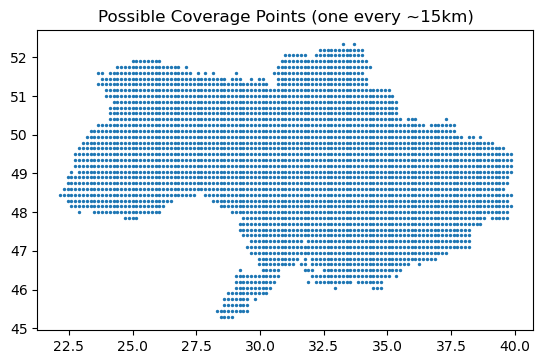

In [23]:
#Generate a 2D grid of points with a .15 degree step (about 15km)
x, y = np.meshgrid(np.arange(22,40.0, .15), np.arange(45.0, 53.0, .15))
x, y = x.flatten(), y.flatten()

possible_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x, y), crs="EPSG:4326"
)

#Clip points to those within Ukraine
clipped_points = possible_points.clip(ua) 

print(len(clipped_points))

f, ax = plt.subplots()
ax.title.set_text("Possible Coverage Points (one every ~15km)")
clipped_points.plot(ax=ax, markersize=2)

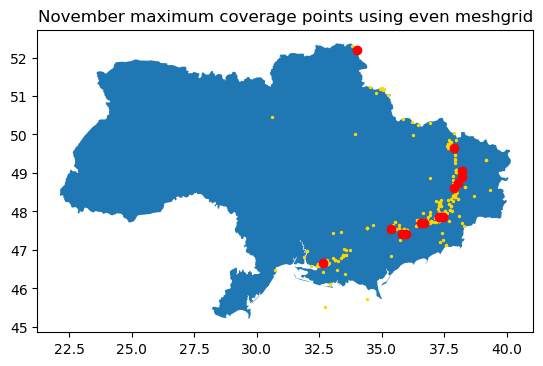

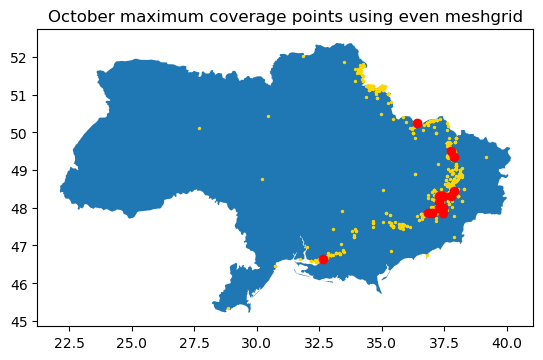

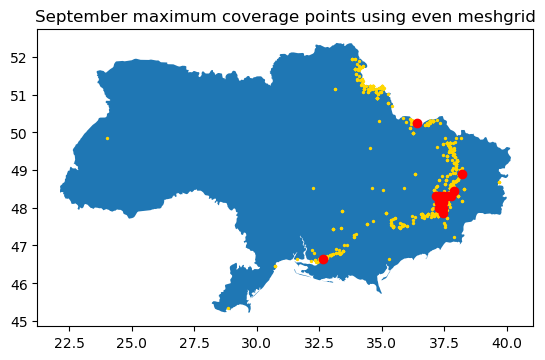

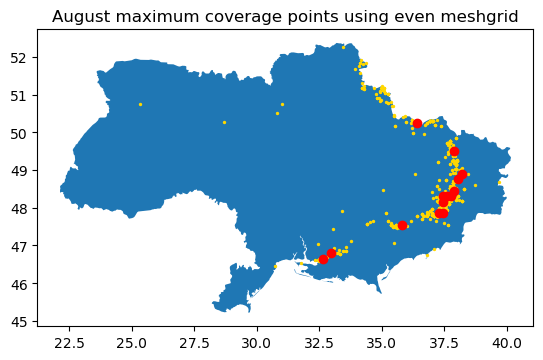

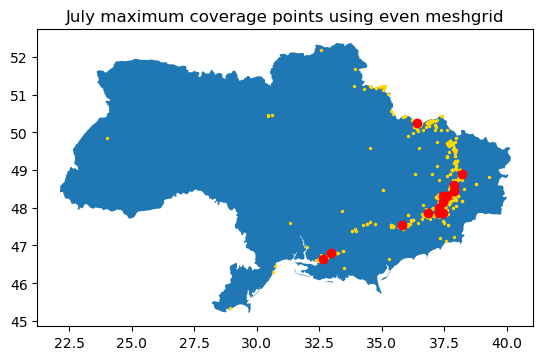

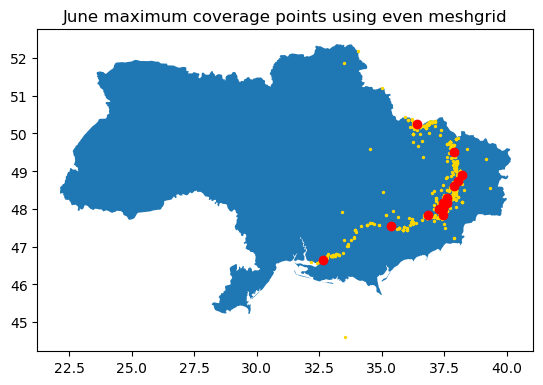

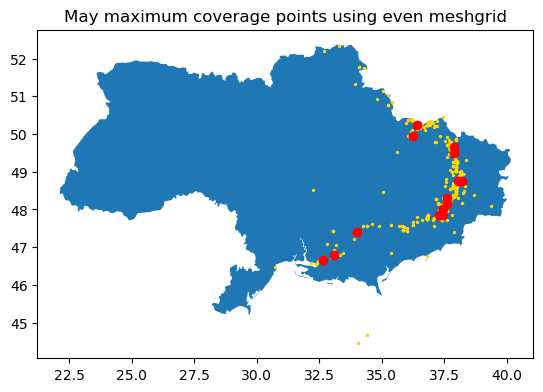

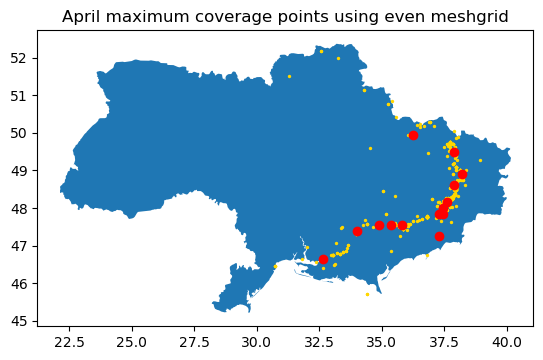

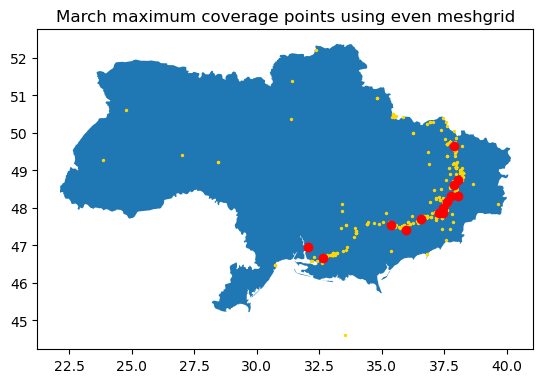

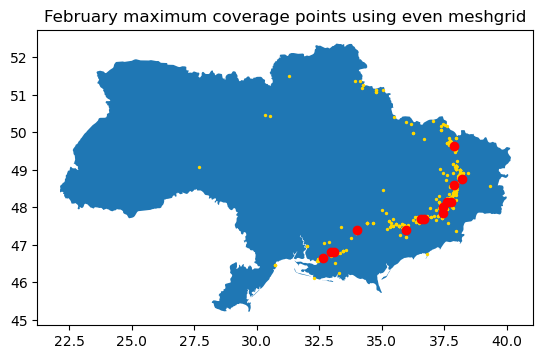

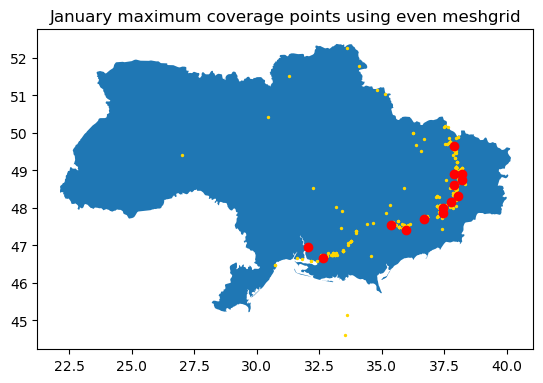

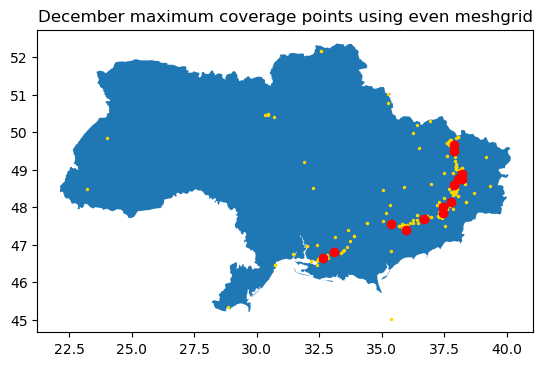

In [25]:
months = ["November","October","September","August","July","June","May","April","March","February","January","December"]

for month in months:
    places = maximum_coverage(filtered_gdf[filtered_gdf['event_date'].str.contains(month)], clipped_points, 14, .05) # .05 for the service_radius is a radius of ~5km

    f, ax = plt.subplots()
    ax.title.set_text(month + " maximum coverage points using even meshgrid")
    ua.plot(ax=ax)
    filtered_gdf[filtered_gdf['event_date'].str.contains(month)].plot(ax=ax, color="gold", markersize=2)
    places.to_crs(ua.crs).plot(ax=ax, color="red", legend_kwds={"label": month, "orientation": "horizontal"})

Total points: 6795


<Axes: title={'center': 'Maximum Coverage Points'}>

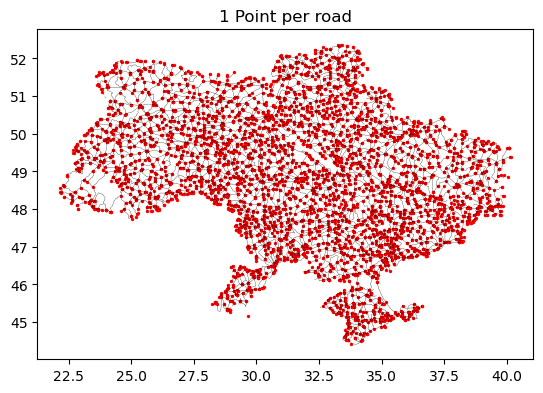

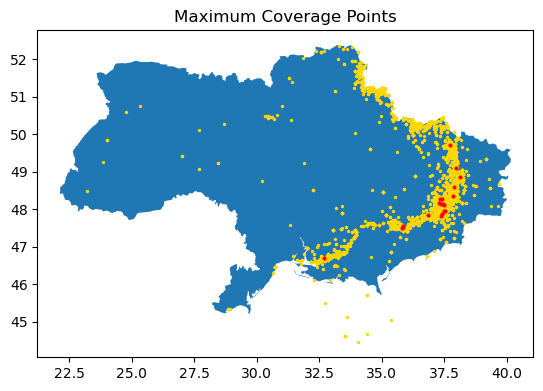

In [24]:
points = []

for index, row in roads.to_crs(filtered_gdf.crs).iterrows():    
    distances = np.linspace(0, row['geometry'].length, 1)
    points.extend([row['geometry'].interpolate(distance) for distance in distances])

print("Total points: " + str(len(points)))

points_gdf = gpd.GeoDataFrame({'geometry': points})

f, ax = plt.subplots()
ax.title.set_text("1 Point per road")
points_gdf.plot(ax=ax, markersize=2, color="RED")
roads.to_crs(filtered_gdf.crs).plot(ax=ax,linewidth=0.2, edgecolor='black')

places = maximum_coverage(filtered_gdf, points_gdf, 20, .1) # .05 for the service_radius is a radius of ~5km

f, ax = plt.subplots()
ax.title.set_text("Maximum Coverage Points")
ua.plot(ax=ax)
filtered_gdf.plot(ax=ax, color="gold", markersize=2)
places.to_crs(ua.crs).plot(ax=ax, color="red", markersize=4)

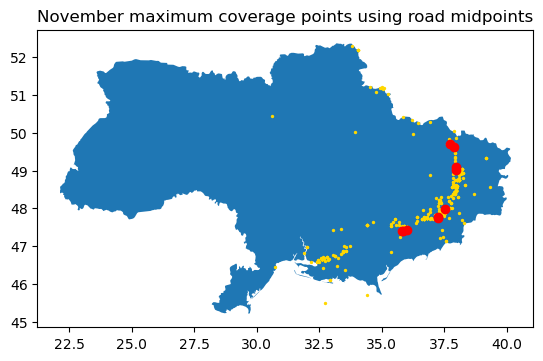

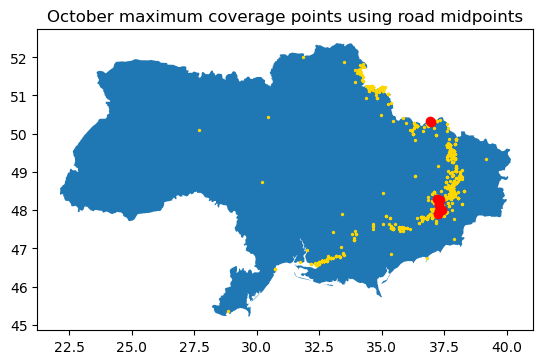

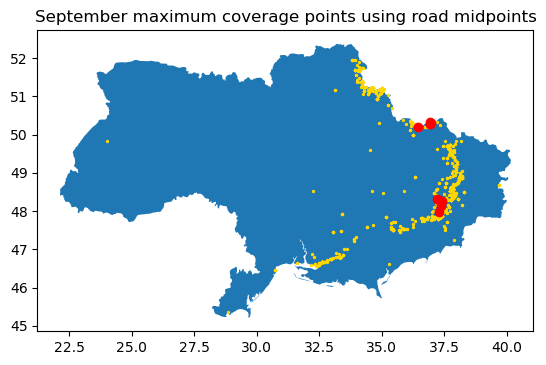

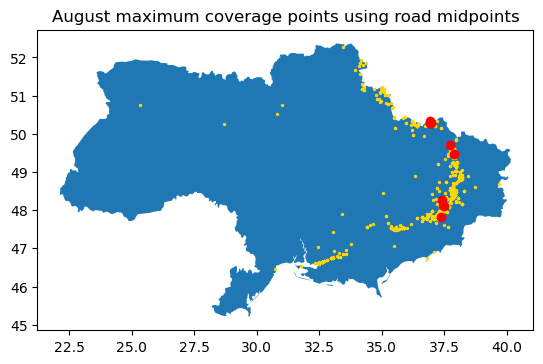

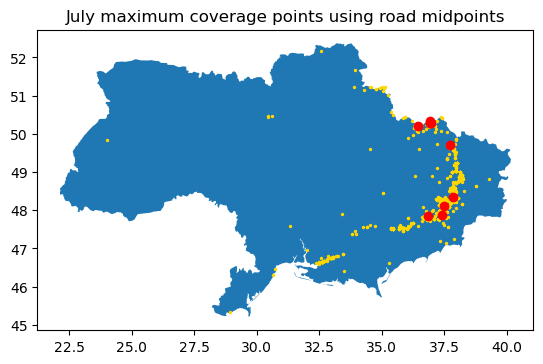

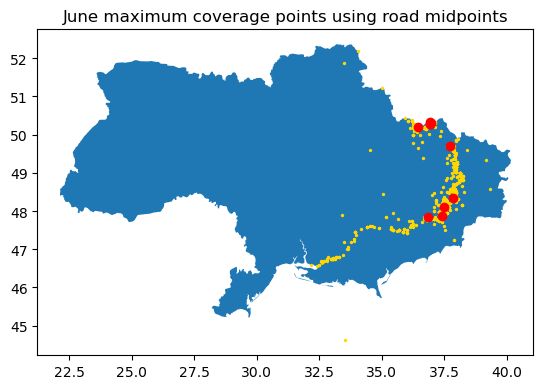

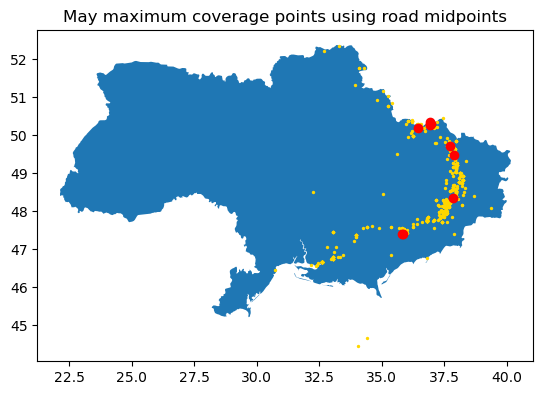

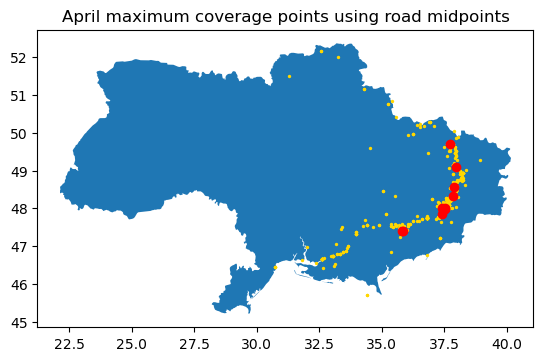

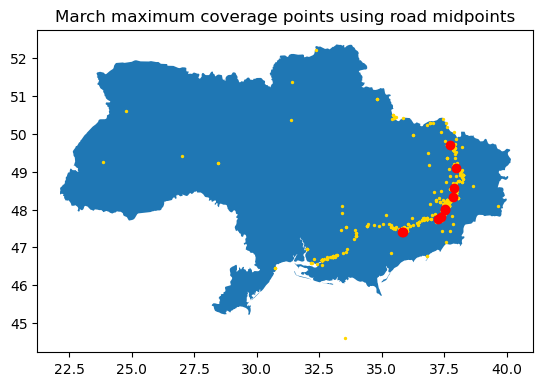

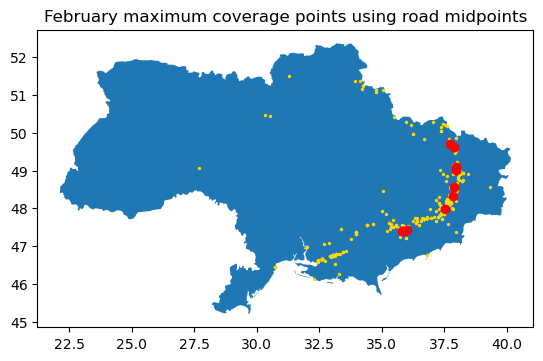

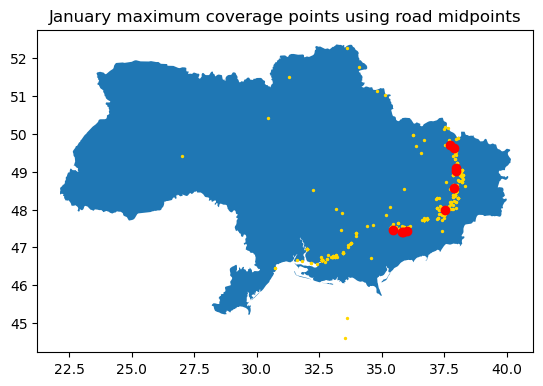

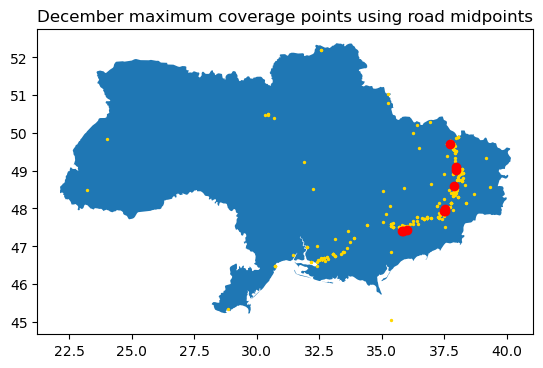

In [26]:
months = ["November","October","September","August","July","June","May","April","March","February","January","December"]

for month in months:
    places = maximum_coverage(filtered_gdf[filtered_gdf['event_date'].str.contains(month)], points_gdf, 10, .05) # .05 for the service_radius is a radius of ~5km

    f, ax = plt.subplots()
    ax.title.set_text(month + " maximum coverage points using road midpoints")
    ua.plot(ax=ax)
    filtered_gdf[filtered_gdf['event_date'].str.contains(month)].plot(ax=ax, color="gold", markersize=2)
    places.to_crs(ua.crs).plot(ax=ax, color="red", legend_kwds={"label": month, "orientation": "horizontal"})

<h4>Maximum coverage points alone would not take danger into account so we opted not to move forward with them except when evaluating safe towns and their proximity to major conflict zones.</h4>

In [ ]:

# Ensure CRS consistency between datasets
roads = roads.to_crs("EPSG:3857")
filtered_gdf = filtered_gdf.to_crs("EPSG:3857")

# Define a buffer around conflict zones (e.g., 50 km)
conflict_buffer = filtered_gdf.buffer(50000)

# Calculate road density around conflict zones
road_density = gpd.sjoin(roads, gpd.GeoDataFrame(geometry=conflict_buffer), how='inner', predicate='intersects')

road_density['road_length'] = road_density.geometry.length

# Summarize road length per conflict zone
road_length_summary = road_density.groupby('index_right')['road_length'].sum().reset_index()
road_length_summary.columns = ['conflict_zone', 'total_road_length']

# Merge back to the conflict dataset
filtered_gdf['total_road_length'] = filtered_gdf.index.map(
    road_length_summary.set_index('conflict_zone')['total_road_length']
)
filtered_gdf['total_road_length'] = filtered_gdf['total_road_length'].fillna(0)


# Ensure CRS is consistent
roads = roads.to_crs("EPSG:3857")
filtered_gdf = filtered_gdf.to_crs("EPSG:3857")

# Calculate intersections
intersections = gpd.overlay(roads, roads, how='intersection')

# Drop duplicate intersections
intersections['geometry'] = intersections.geometry.apply(lambda geom: geom.centroid)
intersections = intersections.drop_duplicates(subset='geometry')

# Add buffer around intersections to calculate road density
intersections['buffer'] = intersections.geometry.buffer(5000)  # 5 km buffer

# Spatial join to find roads within the buffer
intersections_with_roads = gpd.sjoin(roads, gpd.GeoDataFrame(intersections, geometry=intersections['buffer']), how='inner', predicate='intersects')

# Calculate road density
intersections_with_roads['road_length'] = intersections_with_roads.geometry.length
road_density = intersections_with_roads.groupby('index_right')['road_length'].sum().reset_index()
road_density.columns = ['intersection', 'total_road_length']

# Merge road density back to intersections
intersections = intersections.reset_index()
intersections['total_road_length'] = intersections['index'].map(
    road_density.set_index('intersection')['total_road_length']
)
intersections['total_road_length'] = intersections['total_road_length'].fillna(0)

# Calculate proximity to conflict zones
intersections['distance_to_conflict'] = intersections.geometry.apply(
    lambda x: filtered_gdf.distance(x).min()
)

# Normalize scores
intersections['road_score'] = (intersections['total_road_length'] - intersections['total_road_length'].min()) / (
    intersections['total_road_length'].max() - intersections['total_road_length'].min()
)
intersections['conflict_score'] = (intersections['distance_to_conflict'] - intersections['distance_to_conflict'].min()) / (
    intersections['distance_to_conflict'].max() - intersections['distance_to_conflict'].min()
)
intersections['conflict_score'] = 1 - intersections['conflict_score']  # Invert conflict score to prefer safer areas

# Combine scores
intersections['final_score'] = intersections['road_score'] * 0.6 + intersections['conflict_score'] * 0.4

# Sort by final score
ranked_intersections = intersections.sort_values(by='final_score', ascending=False)
ranked_intersections.head()

# Filter intersections on the Ukrainian side
# Define a rough boundary for the "Ukrainian side" (can use polygons for better accuracy)
ukraine_boundary = filtered_gdf.total_bounds  # xmin, ymin, xmax, ymax
xmin, ymin, xmax, ymax = ukraine_boundary
ukrainian_side = xmin + (xmax - xmin) * 0.5  # Midpoint of the map

# Keep points east of the midpoint (Ukrainian side)
ranked_intersections = ranked_intersections[ranked_intersections.geometry.x < ukrainian_side]

# Apply a threshold for the top 10%
score_threshold = ranked_intersections['final_score'].quantile(0.9)
top_intersections = ranked_intersections[ranked_intersections['final_score'] >= score_threshold]


# Convert intersections to WGS84 for visualization
ranked_intersections = ranked_intersections.to_crs("EPSG:4326")

# Initialize a map centered on Ukraine
m = folium.Map(location=[48.3794, 31.1656], zoom_start=6)

# Add intersections to the map
for _, row in ranked_intersections.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        popup=f"Intersection: Score {row['final_score']:.2f}",
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
    ).add_to(m)

# Display the map
m

# Plot top intersections near conflict zones on the Ukrainian side
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Top 10% Supply Station Locations Near Conflict Zones (Ukrainian Side)")

# Plot the roads
roads.plot(ax=ax, linewidth=0.2, edgecolor='gray')

# Plot the conflict zones
filtered_gdf.plot(ax=ax, color='red', markersize=10, label="Conflict Zones")

# Plot the top intersections
top_intersections.plot(
    ax=ax,
    color='blue',
    markersize=30,
    label="Top Supply Station Locations",
    zorder=3,
)

plt.legend()
plt.show()



<img src="./Screenshot 2024-12-04 at 1.42.56 PM.png" />

<h4>This plot was far too heavy and took a huge amount of time to be generated. It also had some outlier issues with it and only looked at towns on the left half of the map instead of within a buffer of the frontline.</br></br> Our final map made use of several of our methods here, it used only our maximum coverage points to lighten the computational load and from those points it generated, close, somewhat safe, and well connected points for humanitarian aid stations. </h4>

<center><h2><strong>Literature Engagements</strong></h2></center>

<img src="./Screenshot 2024-12-04 at 1.21.26 PM.png"/>


<br/>

<h3>In this article they explored coverage optimization and ways of presenting how more points may reduce the return on investment of individual points being added. Although this didn't end up having much of an effect on our submission we had been trying to find ways to present proof of optimal positionaing and we had explored employing a graphic similar to this one.</h3>
</br>
<h5>Murray, A. T., & Tong, D. (2007). Coverage optimization in continuous space facility siting. International Journal of Geographical Information Science, 21(7), 757–776. https://doi.org/10.1080/13658810601169857</h5>
</br>
</br>
</br>
<h3>Geographic Information Systems (GIS) play a crucial role in humanitarian assistance by helping organizations assess risks, identify vulnerable populations, and support decision-making during disaster relief efforts. Risk and vulnerability assessments are particularly important for understanding where aid is needed most. Risk assessments identify “hotspots” by combining hazard data, such as natural disaster risks, with information about vulnerable populations. Vulnerability assessments further support this process by integrating socio-economic and environmental data to predict which areas are likely to be most affected. This combination helps prioritize locations for aid delivery, ensuring resources are used effectively and lives are saved.</br>
</br>
GIS also enhances decision-making by supporting the allocation and distribution of resources. Through location analysis, GIS can determine the best places for shelters, supply warehouses, and other key facilities, while avoiding areas prone to hazards such as flooding. Scenario modeling is another essential tool, allowing organizations to simulate disaster outcomes and assess different response strategies. By analyzing “what-if” scenarios, decision-makers can plan more effectively and minimize the consequences of disasters. These tools are particularly valuable during the response phase of disasters when speed and accuracy are critical.</h3></br>
<h5>Ortiz, D. 2020. Geographic Information Systems (GIS) in Humanitarian Assistance: A Meta-Analysis. Pathways: A Journal of Humanistic and Social Inquiry. 1(2).</h5>

<>